In [1]:
!pip install torchvision
!pip install --upgrade transformers
!pip install mmocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [2]:
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

zipPath = '/content/drive/MyDrive/train_val_images.zip'
zipPathTest = '/content/drive/MyDrive/test_images.zip'
annsPathTrain = '/content/drive/MyDrive/TextOCR_0.1_train.json'
annsPathVal = '/content/drive/MyDrive/TextOCR_0.1_val.json'
annsPathTest = '/content/drive/MyDrive/TextOCR_0.1_test.json'
stepDir = "/content/drive/MyDrive/checkpoint_coreset/donut/"

diversityPath = "/content/drive/MyDrive/Core-sets/DiversityClustering.zip"
annsDiversity = "/content/drive/MyDrive/Core-sets/DiversityClustering.json"
hardPath = "/content/drive/MyDrive/Core-sets/HardClustering.zip"
annsHard = "/content/drive/MyDrive/Core-sets/HardClustering.json"
dhPath = "/content/drive/MyDrive/Core-sets/DHClustering.zip"
dhHard = "/content/drive/MyDrive/Core-sets/DHClustering.json"

Mounted at /content/drive


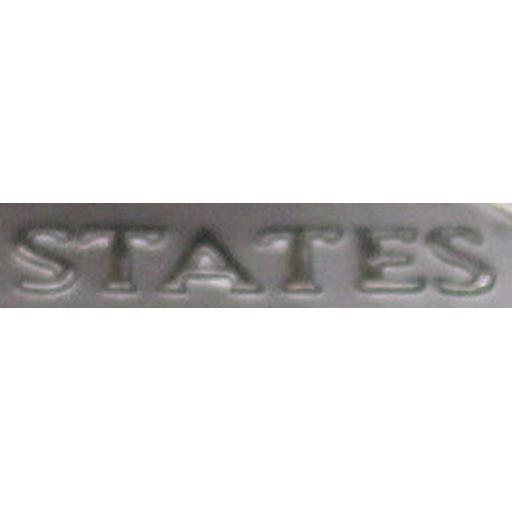

In [4]:
import zipfile
from PIL import Image
from IPython.display import display
import io

data = zipfile.ZipFile(diversityPath, 'r')
images = [f for f in data.namelist() if f.endswith('.jpg')]
file = data.open(images[0])
img = Image.open(io.BytesIO(file.read())).convert("RGB")
display(img)

In [5]:
from transformers import VisionEncoderDecoderModel, DonutProcessor

if os.path.exists("/content/drive/MyDrive/models_coreset/model"):
  model = VisionEncoderDecoderModel.from_pretrained("/content/drive/MyDrive/models_coreset/model")
elif os.path.exists(stepDir):
  model = VisionEncoderDecoderModel.from_pretrained(stepDir)
else:
  model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
processor.feature_extractor.size = {"height": 512, "width": 512}
print(processor.image_processor.size)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/362 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/71.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/355 [00:00<?, ?B/s]

{'height': 512, 'width': 512}


/usr/local/lib/python3.11/dist-packages/transformers/models/donut/processing_donut.py:217: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [6]:
from PIL import ImageOps
import json
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import numpy as np
import random

class CoreDataset(Dataset):
  def __init__(self, zipPath, annsPath, processor, isTest, maxLength = 50, maxSamples = None):
    self.zipPath = zipPath
    self.annsPath = annsPath
    self.processor = processor
    self.maxLength = maxLength
    self.archive = zipfile.ZipFile(self.zipPath, 'r')

    with open(self.annsPath, 'r') as f:
      self.annotations = json.load(f)

    with zipfile.ZipFile(zipPath, 'r') as zipRef:
      filenames = zipRef.namelist()

    self.samples = []
    idx = 0
    for label in self.annotations:
      self.samples.append((filenames[idx], label))
      if len(self.samples) == maxSamples:
        break
      idx += 1


  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    zipImgPath, label = self.samples[idx]
    with self.archive.open(zipImgPath) as f:
      img = Image.open(io.BytesIO(f.read())).convert("RGB")
    pixelValues = self.processor(img, return_tensors = "pt").pixel_values[0]
    labels = self.processor.tokenizer(label, max_length = self.maxLength, padding = "max_length", truncation = True, return_tensors = "pt").input_ids.squeeze(0)
    labels[labels == self.processor.tokenizer.pad_token_id] = -100
    return {"pixel_values": pixelValues, "labels": labels}

  def sendItem(self, idx):
    zipImgPath, label = self.samples[idx]
    with self.archive.open(zipImgPath) as f:
      img = Image.open(io.BytesIO(f.read())).convert("RGB")
    return img, label

  def printLabel(self, idx):
    _ , label = self.samples[idx]
    print(label)

In [7]:
from PIL import ImageOps

def resizeMaintainRatio(image, size=(1920, 2560)):
  w, h = image.size
  scale = min(size[0] / w, size[1] / h)
  newW, newH = int(w * scale), int(h * scale)
  newImg = image.resize((newW, newH))

  deltaW = size[0] - newW
  deltaH = size[1] - newH
  padding = (deltaW // 2, deltaH // 2, deltaW - (deltaW // 2), deltaH - (deltaH // 2))
  newImg = ImageOps.expand(newImg, padding, fill = (255, 255, 255))
  return newImg

In [8]:
class ZippedDataset(Dataset):
  def __init__(self, zipPath, annsPath, processor, isTest, maxLength = 50, maxSamples = None):
    self.zipPath = zipPath
    self.annsPath = annsPath
    self.processor = processor
    self.maxLength = maxLength
    self.archive = zipfile.ZipFile(self.zipPath, 'r')

    with open(self.annsPath, 'r') as f:
      annotations = json.load(f)
    self.imgs = annotations["imgs"]
    self.anns = annotations["anns"]

    self.samples = []
    minBox = (20, 20)
    img = None
    curImgID = ""
    for ann in self.anns.values():
      imgID = ann["image_id"]
      text = ann["utf8_string"].strip()
      bbox = ann["bbox"]
      zipImgPath = self.imgs[imgID]["file_name"]
      zipImgPath = zipImgPath.replace("test/", "test_images/") if isTest else zipImgPath.replace("train/", "train_images/")
      if img is None or imgID != curImgID:
        with self.archive.open(zipImgPath) as f:
          img = Image.open(io.BytesIO(f.read())).convert("RGB")
        curImgID = imgID
      x, y, w, h = bbox
      if w < minBox[0] or h < minBox[1]:
        continue
      cropped = img.crop((x, y, x + w, y + h))
      if self.tooBlurry(cropped) or text == "" or text == ".":
        continue
      self.samples.append((zipImgPath, bbox, text))
      if len(self.samples) == maxSamples:
        break

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    zipImgPath, bbox, label = self.samples[idx]
    with self.archive.open(zipImgPath) as f:
      img = Image.open(io.BytesIO(f.read())).convert("RGB")
    x, y, w, h = bbox
    cropped = img.crop((x, y, x + w, y + h))
    cropped = resizeMaintainRatio(cropped, (512, 512))
    pixelValues = self.processor(cropped, return_tensors = "pt").pixel_values[0]
    labels = self.processor.tokenizer(label, max_length = self.maxLength, padding = "max_length", truncation = True, return_tensors = "pt").input_ids.squeeze(0)
    labels[labels == self.processor.tokenizer.pad_token_id] = -100
    return {"pixel_values": pixelValues, "labels": labels}

  def sendItem(self, idx):
    zipImgPath, bbox, label = self.samples[idx]
    with self.archive.open(zipImgPath) as f:
      img = Image.open(io.BytesIO(f.read())).convert("RGB")
    x, y, w, h = bbox
    cropped = img.crop((x, y, x + w, y + h))
    cropped = resizeMaintainRatio(cropped, (512, 512))
    return cropped, label

  def tooBlurry(self, img, threshold = 100):
    img = np.array(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian < threshold

  def printLabel(self, idx):
    _ , label = self.samples[idx]
    print(label)

In [9]:
from torch.utils.data import random_split
import torch

datasetTrain = CoreDataset(dhPath, dhHard, processor, False)
generator = torch.Generator().manual_seed(44)
datasubTrain, datasubVal = random_split(datasetTrain, [int(len(datasetTrain) * 0.9), len(datasetTrain) - int(len(datasetTrain) * 0.9)], generator = generator)
dataloaderTrain = DataLoader(datasubTrain, batch_size = 24, shuffle = True)
dataloaderVal = DataLoader(datasubVal, batch_size = 1)
print(len(datasubTrain))
print(len(datasubVal))

7200
800


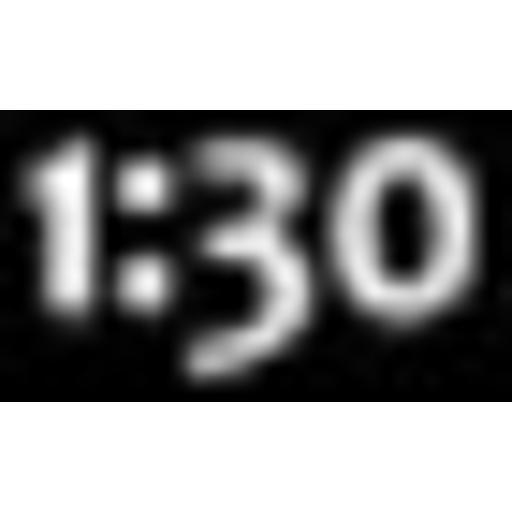

1:30


In [10]:
img, label = datasetTrain.sendItem(10)
display(img)
print(label)

In [11]:
model.config.decoder_start_token_id = processor.tokenizer.bos_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.eos_token_id = processor.tokenizer.eos_token_id

print("Decoder start token:", processor.tokenizer.convert_ids_to_tokens(model.config.decoder_start_token_id))
print("Pad token:", processor.tokenizer.pad_token, "ID:", model.config.pad_token_id)
print("EOS token:", processor.tokenizer.eos_token, "ID:", model.config.eos_token_id)

Decoder start token: <s>
Pad token: <pad> ID: 1
EOS token: </s> ID: 2


In [12]:
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

numEpochs = 10
accumulationSteps = 4
numTrainingSteps = numEpochs * len(dataloaderTrain)
optimizer = AdamW(model.parameters(), lr = 2e-5, weight_decay=0.01)
lrScheduler = get_linear_schedule_with_warmup(optimizer = optimizer, num_warmup_steps = 1000, num_training_steps = numTrainingSteps)
if os.path.exists(stepDir):
  optimizer.load_state_dict(torch.load(os.path.join(stepDir, "optimizer.pt")))
  lrScheduler.load_state_dict(torch.load(os.path.join(stepDir, "lrScheduler.pt")))

In [13]:
import gc
import torch

torch.cuda.empty_cache()
gc.collect()
torch.cuda.ipc_collect()

In [14]:
class EarlyStopping:
  def __init__(self, patience = 1, delta = 0):
    self.patience = patience
    self.delta = delta
    self.counter = 0
    self.bestLoss = float("inf")
    self.earlyStop = False

  def __call__(self, valLoss):
    if valLoss < self.bestLoss - self.delta:
      self.bestLoss = valLoss
      self.counter = 0
    else:
      self.counter += 1
      if self.counter >= self.patience:
        self.earlyStop = True

In [15]:
import torch.nn.functional as F

def labelSmoothedNLLLoss(logits, target, epsilon = 0.1, ignoreIdx = -100):
  target = torch.clamp(target, 0, logits.size(-1) - 1)
  mask = target != ignoreIdx
  logProbs = F.log_softmax(logits, dim = -1)
  nClasses = logits.size(-1)
  trueDist = torch.zeros_like(logProbs)
  trueDist.fill_(epsilon / (nClasses - 1))
  trueDist.scatter_(2, target.unsqueeze(-1), 1 - epsilon)
  loss = -(trueDist * logProbs).sum(dim = -1)
  loss = loss[mask]
  return loss.mean()

def tokenConfidencePenalty(logits):
  logProbs = F.log_softmax(logits, dim = -1)
  entropy = -torch.sum(torch.exp(logProbs) * logProbs, dim = -1)
  return entropy.mean()

In [16]:
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()
earlyStopper = EarlyStopping(patience = 0)
model.gradient_checkpointing_enable()
if os.path.exists(stepDir):
  with open(os.path.join(stepDir, "meta.json"), "r") as f:
    meta = json.load(f)
  globalStep = meta.get("global_step", 0)
  startEpoch = meta.get("epoch", 0)
else:
  globalStep = 0
  startEpoch = 0
lenPenalty = 0.05

for epoch in range(startEpoch, numEpochs):
  print(f"Epoch {epoch + 1}/{numEpochs}")
  runningLoss = 0.0
  model.train()
  optimizer.zero_grad()
  trainLoss = 0.0
  pbar = tqdm(dataloaderTrain, desc = "Training")
  for step, batch in enumerate(pbar):
    batch = {k: v.to(device) for k, v in batch.items()}
    with autocast(enabled = True):
      outputs = model(**batch)
      logits = outputs.logits
      labels = batch["labels"]
      loss = labelSmoothedNLLLoss(logits, labels, epsilon = 0.1)
      predictedIDs = logits.detach().argmax(dim = -1)
      predictedLengths = (predictedIDs != processor.tokenizer.pad_token_id).sum(dim = 1).float()
      avgLength = predictedLengths.mean()
      loss = loss + lenPenalty * avgLength
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    lrScheduler.step()
    optimizer.zero_grad()

    runningLoss += loss.item()
    pbar.set_postfix(loss = runningLoss / (step + 1))

  del loss, outputs, batch
  gc.collect()
  avgTrainLoss = runningLoss / len(dataloaderTrain)
  print(f"Training loss: {avgTrainLoss:.4f}")

  model.eval()
  valLoss = 0.0
  with torch.no_grad():
    for batch in dataloaderVal:
      batch = {k: v.to(device) for k, v in batch.items()}
      with autocast(enabled = True):
        outputs = model(**batch)
        loss = outputs.loss
      valLoss += loss.item()
  avgValLoss = valLoss / len(dataloaderVal)
  print(f"Validation loss: {avgValLoss:.4f}")
  earlyStopper(avgValLoss)
  if earlyStopper.earlyStop:
    print("Early stopping!")
    break

  os.makedirs(stepDir, exist_ok = True)
  model.save_pretrained(stepDir)
  processor.save_pretrained(stepDir)
  torch.save(optimizer.state_dict(), os.path.join(stepDir, "optimizer.pt"))
  torch.save(lrScheduler.state_dict(), os.path.join(stepDir, "lrScheduler.pt"))
  with open(os.path.join(stepDir, "meta.json"), "w") as f:
    json.dump({"global_step": globalStep, "epoch": epoch}, f)

  torch.cuda.empty_cache()
  del loss, outputs, batch
  gc.collect()
  torch.cuda.ipc_collect()

<ipython-input-16-aaa14dfb309c>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 2/10


Training:   0%|          | 0/300 [00:00<?, ?it/s]<ipython-input-16-aaa14dfb309c>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled = True):
`use_cache=True` is incompatible with gradient checkpointing`. Setting `use_cache=False`...
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
Training: 100%|██████████| 300/300 [12:12<00:00,  2.44s/it, loss=4.19]
<ipython-input-16-aaa14dfb309c>:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled = True):
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Training loss: 4.1942
Validation loss: 8.0990
Epoch 3/10


Training: 100%|██████████| 300/300 [12:07<00:00,  2.43s/it, loss=4.1]


Training loss: 4.1019
Validation loss: 9.1690
Early stopping!


In [17]:
model.save_pretrained("/content/drive/MyDrive/models_coreset/dh_model")

In [18]:
datasetTest = ZippedDataset(zipPath, annsPathVal, processor, False, maxSamples = 4000)
dataloaderTest = DataLoader(datasetTest, batch_size = 1)
print(len(datasetTest))

4000


In [19]:
!pip install jiwer

In [20]:
from jiwer import cer
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

model.eval()
totalCER = 0.0
results = []
idx = 0

for batch in tqdm(dataloaderTest, desc = "Testing"):
  with torch.no_grad():
    pixelValues = batch["pixel_values"].to(device)
    labels = batch["labels"].clone()
    labels[labels == -100] = processor.tokenizer.pad_token_id
    outputs = model.generate(pixelValues, max_length = 50, num_beams = 1, do_sample = False, early_stopping = True)
    decode = processor.batch_decode(outputs, skip_special_tokens = True)
    labelStr = processor.batch_decode(labels, skip_special_tokens = True)
    for pred, ref in zip(decode, labelStr):
      if not ref == "":
        result = {"idx": idx, "prediction": pred, "label": ref}
        results.append(result)
        idx += 1

avgCer = sum(cer(r["label"], r["prediction"]) for r in results) / len(results)
print(f"CER: {avgCer:.4f}")
print("Sample prediction")
print("Pred:", results[0]["prediction"])
print("Label:", results[0]["label"])

Testing:   0%|          | 1/4000 [00:00<31:19,  2.13it/s]The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Testing:   0%|          | 3/4000 [00:00<12:07,  5.49it/s]The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Testing:   0%|          | 5/4000 [00:00<08:38,  7.70it/s]The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Testing

CER: 0.4671
Sample prediction
Pred: RICHARD
Label: RICHARD


In [ ]:
print(results[9])

{'idx': 9, 'prediction': 'MORGAN', 'label': 'moRGAn'}


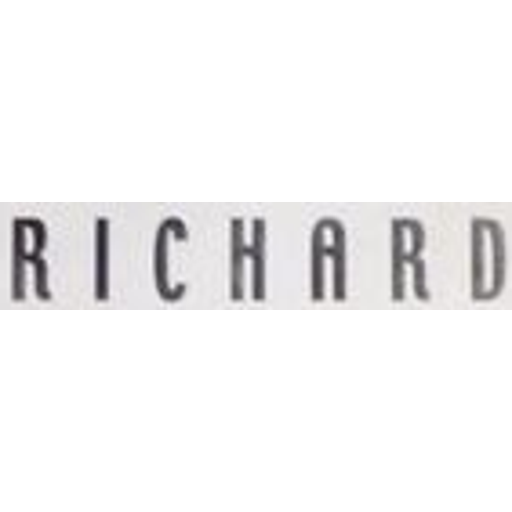

RICHARD


In [ ]:
img, label = datasetTest.sendItem(0)
display(img)
print(label)

In [21]:
os.makedirs("/content/drive/MyDrive/DonutResults_coreset", exist_ok = True)

In [22]:
with open("/content/drive/MyDrive/DonutResults_coreset/results_dh.json", "w") as f:
  json.dump({
    "average_CER": avgCer,
    "results": results
  }, f, indent=2)

In [23]:
data.close()